# GAN


## 실습 목표
-----
- GAN을 사용하여 이미지 생성 모델을 만듬 (데이터셋: CIFAR10)


## GAN

### [Step1] Load libraries & Datasets

In [1]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt

import torchvision.utils as utils
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision import datasets

from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
image_size = 64
dataset = datasets.CIFAR10(root='data', download = True,
                          transform = transforms.Compose([
                            transforms.Resize(image_size),
                            transforms.CenterCrop(image_size),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

100%|██████████| 170M/170M [00:03<00:00, 43.3MB/s]


### [Step2] Set hyperparameters

In [3]:
n_epochs = 5
batch_size = 128
lr = 0.0002
b1 = 0.5
b2 = 0.999
latent_dim = 100
channels = 1
sample_interval = 400
device = torch.device("cuda" if(torch.cuda.is_available()) else "cpu")

### [Step3] Create DataLoader

In [4]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

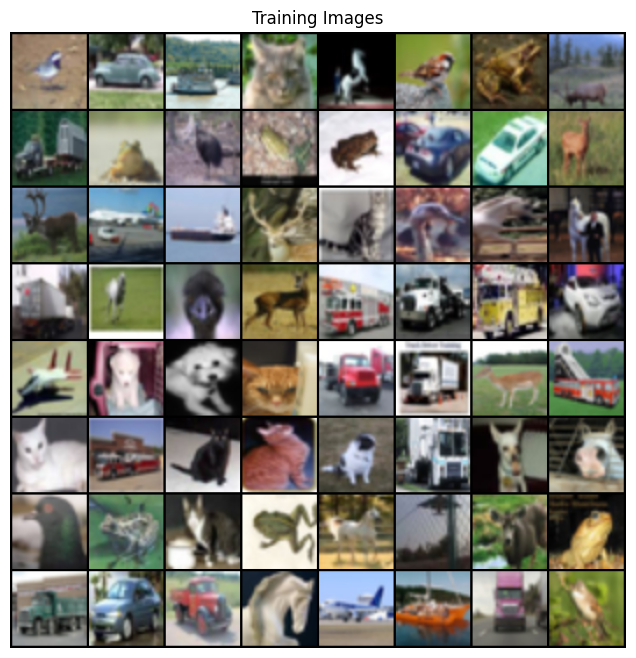

In [5]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

###[Step4] Weight init

In [6]:
def weights_init(w):
    classname = w.__class__.__name__
    if classname.find('conv') != -1:
        nn.init.normal_(w.weight.data, 0.0, 0.02)
    elif classname.find('bn') != -1:
        nn.init.normal_(w.weight.data, 1.0, 0.02)
        nn.init.constant_(w.bias.data, 0)

### [Step5] Set Network Structure

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.tconv1 = nn.ConvTranspose2d(100, 64*8, kernel_size=4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(64*8)
        self.tconv2 = nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64*4)
        self.tconv3 = nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64*2)
        self.tconv4 = nn.ConvTranspose2d(64*2, 64, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)
        self.tconv5 = nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False)

    def forward(self, x):
        x = F.relu(self.bn1(self.tconv1(x)))
        x = F.relu(self.bn2(self.tconv2(x)))
        x = F.relu(self.bn3(self.tconv3(x)))
        x = F.relu(self.bn4(self.tconv4(x)))
        x = F.tanh(self.tconv5(x))

        return x

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False) # 3 x 64 x 64
        self.conv2 = nn.Conv2d(64, 64*2, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64*2)
        self.conv3 = nn.Conv2d(64*2, 64*4, 4, 2, 1, bias=False) # 64 x 2 x 16 x 16
        self.bn3 = nn.BatchNorm2d(64*4)
        self.conv4 = nn.Conv2d(64*4, 64*8, 4, 2, 1, bias=False)# 64 x 4 x 8 x 8
        self.bn4 = nn.BatchNorm2d(64*8)
        self.conv5 = nn.Conv2d(64*8, 1, 4, 1, 0, bias=False)# 64 x 4 x 4 x 4

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2, True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2, True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2, True)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2, True)
        x = F.sigmoid(self.conv5(x))

        return x

### [Step6] Create Model instance

In [10]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator.apply(weights_init)
discriminator.apply(weights_init)

print(generator)
print(discriminator)

Generator(
  (tconv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)
Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(

### [Step7] Model compile

In [11]:
# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [12]:
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

real_label = 1.
fake_label = 0.

### [Step8] Training model
1. Discriminator 학습
    - real data로 학습
    - fake data로 학습
2. Generator 학습

In [13]:
img_list = []
G_losses = []
D_losses = []
iters = 0
for epoch in range(n_epochs):
    for i, data in enumerate(dataloader, 0):
        # 1. Discriminator 학습
        # 1-1. Real data
        real_img = data[0].to(device)
        b_size = real_img.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        discriminator.zero_grad()
        output = discriminator(real_img).view(-1)
        real_loss = adversarial_loss(output, label)
        real_loss.backward()
        D_x = output.mean().item()

        # 1-2. Fake data
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake = generator(noise)
        label.fill_(fake_label)

        output = discriminator(fake.detach()).view(-1)
        fake_loss = adversarial_loss(output, label)
        fake_loss.backward()

        D_G_z1 = output.mean().item()
        disc_loss = real_loss + fake_loss

        optimizer_D.step()

        # 2. Generator 학습
        generator.zero_grad()
        label.fill_(real_label)
        output = discriminator(fake).view(-1)
        gen_loss = adversarial_loss(output, label)
        gen_loss.backward()
        D_G_z2 = output.mean().item()
        optimizer_G.step()

        if i % 50 == 0:
            print('[{}/{}][{}/{}]'.format(epoch+1, n_epochs, i, len(dataloader)))
            print('Discriminator Loss:{:.4f}\t Generator Loss:{:.4f}\t D(x):{:.4f}\t D(G(z)):{:.4f}/{:.4f}'.format(disc_loss.item(), gen_loss.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(gen_loss.item())
        D_losses.append(disc_loss.item())

        if (iters % 500 == 0) or ((epoch == n_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))

        iters += 1

[1/5][0/391]
Discriminator Loss:1.3651	 Generator Loss:2.9928	 D(x):0.4676	 D(G(z)):0.4394/0.0525


KeyboardInterrupt: 

### [Step9] Visualizing generated data

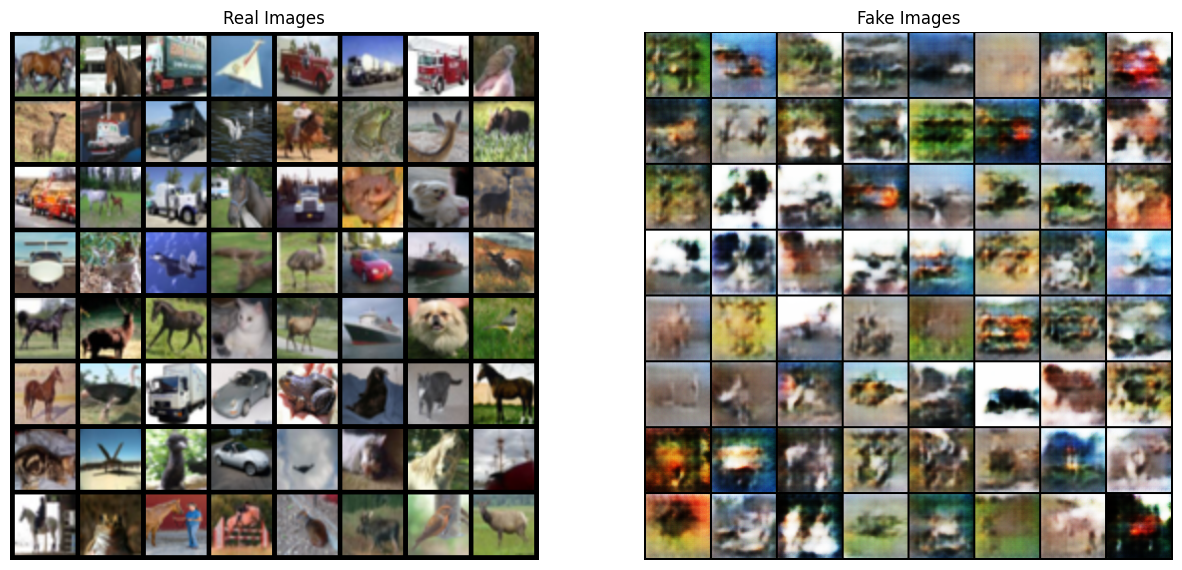

In [ ]:
#real images
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

#generated images
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()